In [5]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import time

In [6]:
characters = pd.read_csv('merged.csv')

In [45]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rank         1000 non-null   int64 
 1   name         1000 non-null   object
 2   anime        984 non-null    object
 3   favorites    1000 non-null   int64 
 4   url          1000 non-null   object
 5   description  997 non-null    object
 6   image        100 non-null    object
 7   Age          437 non-null    object
 8   Birthday     58 non-null     object
 9   Nationality  15 non-null     object
 10  Height       456 non-null    object
 11  Occupation   74 non-null     object
 12  image.1      1000 non-null   object
dtypes: int64(2), object(11)
memory usage: 101.7+ KB


In [8]:
description_errors = characters['description'].str.startswith('Error processing').sum()

image_errors = characters['image.1'].str.startswith('Error processing').sum()

total_errors = (
    characters['description'].str.startswith('Error processing') |
    characters['image.1'].str.startswith('Error processing')
).sum()

print(f"Number of 'Error processing' in description: {description_errors}")
print(f"Number of 'Error processing' in image.1: {image_errors}")
print(f"Total rows with 'Error processing' in either column: {total_errors}")


Number of 'Error processing' in description: 89
Number of 'Error processing' in image.1: 96
Total rows with 'Error processing' in either column: 177


In [4]:
from imgutils.config.meta import __TITLE__, __AUTHOR__, __VERSION__, __DESCRIPTION__
from imgutils.detect import detect_faces, detection_visualize
if __name__ == '__main__':
    print(__TITLE__, __VERSION__)
    print('Developed and maintained by', __AUTHOR__)
    print(__DESCRIPTION__)

/Users/yirenlu/Documents/data_studio/Final/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


imgutils 0.16.0
Developed and maintained by narugo1992, 7eu7d7
A convenient and user-friendly anime-style image data processing library that integrates various advanced anime-style image processing models.


In [13]:
image = 'https://cdn.myanimelist.net/images/characters/2/241413.jpg'
result = detect_faces(image)
result

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


[((23, 94, 183, 262), 'face', 0.7703894376754761)]

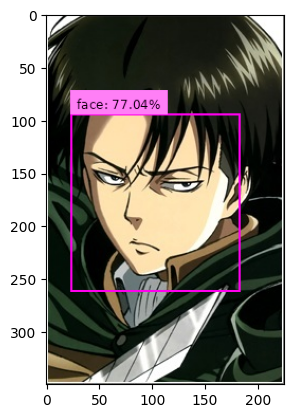

In [16]:
from matplotlib import pyplot as plt
plt.imshow(detection_visualize(image, result))
plt.show()

# Create a Model to detect the skin tone from the face

In [1]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from io import BytesIO
import requests

In [40]:

def extract_dominant_color(url, n_colors=3):
    # Load image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    # Detect face(s)
    results = detect_faces(url)

    # Use only the first detected face
    box, label, score = results[0]
    x1, y1, x2, y2 = box

    # Crop the detected face area
    face_region = image.crop((x1, y1, x2, y2))
    face_pixels = np.array(face_region).reshape(-1, 3)

    # Run KMeans to find dominant colors
    kmeans = KMeans(n_clusters=n_colors, random_state=0)
    kmeans.fit(face_pixels)
    centers = kmeans.cluster_centers_.astype(int)

    # Count how many pixels belong to each cluster
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    dominant_color = centers[np.argmax(counts)]

    return tuple(dominant_color)


In [37]:
extract_dominant_color(url)

(21, 24, 14)

In [43]:
skin = []
characters_image = characters['image.1']
for ch in characters_image:
    try:
        skin.append(extract_dominant_color(ch))
    except Exception as e:
        skin.append(None)


In [44]:
len(skin)

1000

In [48]:
merged = pd.concat([characters, pd.DataFrame({'skin': skin})], axis=1)

In [50]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rank         1000 non-null   int64 
 1   name         1000 non-null   object
 2   anime        984 non-null    object
 3   favorites    1000 non-null   int64 
 4   url          1000 non-null   object
 5   description  997 non-null    object
 6   image        100 non-null    object
 7   Age          437 non-null    object
 8   Birthday     58 non-null     object
 9   Nationality  15 non-null     object
 10  Height       456 non-null    object
 11  Occupation   74 non-null     object
 12  image.1      1000 non-null   object
 13  skin         865 non-null    object
dtypes: int64(2), object(12)
memory usage: 109.5+ KB


# Extract the adjectives

In [56]:
import spacy

# Load English language model
nlp = spacy.load("en_core_web_sm")

In [65]:
names = characters['name']

#### if there is adj in the description

In [86]:
def extract_adjectives(text):
   # Process the text
    doc = nlp(text)

    adjectives = []
    for token in doc:
        if token.pos_ == "ADJ":
            # Filter adjectives that are descriptive, and not just part of other nouns
            if token.head.text.lower() in ["is", "was", "are", "seems", "acts", "looks"]:
                adjectives.append(token.text)
    # Remove names
    adjectives = [adj for adj in adjectives if not names.str.contains(adj, case=False).any()]
    # Remove duplicates and print results
    adjectives = list(set(adjectives))
    if len(adjectives) > 0:
        return adjectives[0]
    else:
        return None

In [87]:
des = merged['description']
associated = []

In [88]:
for text in des:
    try:
        associated.append(extract_adjectives(text))
    except Exception as e:
        associated.append(None)

In [89]:
len(associated)

1000

In [90]:
merged = pd.concat([merged, pd.DataFrame({'associated': associated})], axis=1)

In [91]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rank         1000 non-null   int64 
 1   name         1000 non-null   object
 2   anime        984 non-null    object
 3   favorites    1000 non-null   int64 
 4   url          1000 non-null   object
 5   description  997 non-null    object
 6   image        100 non-null    object
 7   Age          437 non-null    object
 8   Birthday     58 non-null     object
 9   Nationality  15 non-null     object
 10  Height       456 non-null    object
 11  Occupation   74 non-null     object
 12  image.1      1000 non-null   object
 13  skin         865 non-null    object
 14  associated   997 non-null    object
 15  associated   475 non-null    object
dtypes: int64(2), object(14)
memory usage: 125.1+ KB


In [93]:
merged.head()
merged.to_csv('merged.csv', index=False)

In [96]:
cols = ['name', 'image.1', 'description', 'skin', 'associated']
words = merged[merged['skin'].notna() & merged['associated'].notna()][cols]


In [97]:
words.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 2 to 998
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         416 non-null    object
 1   image.1      416 non-null    object
 2   description  416 non-null    object
 3   skin         416 non-null    object
 4   associated   416 non-null    object
dtypes: object(5)
memory usage: 19.5+ KB


In [98]:
words.head()

,name,image.1,description,skin,associated
2,Levi(リヴァイ),https://cdn.myanimelist.net/images/characters/...,"Birthday: December 25 \n Height: 160 cm (5'3"")...","(21, 24, 14)",blunt
7,"Okabe, Rintarou(岡部 倫太郎)",https://cdn.myanimelist.net/images/characters/...,"Age: 18 (Steins;Gate), 19 (Steins;Gate 0) \n B...","(241, 221, 201)",hesitant
9,"Uzumaki, Naruto(うずまき ナルト)",https://cdn.myanimelist.net/images/characters/...,"Age: 12-13 (Naruto part I), 15-17 (part II), 1...","(220, 166, 132)",capable
13,"Makise, Kurisu(牧瀬 紅莉栖)",https://cdn.myanimelist.net/images/characters/...,Age: 18 \n Birthdate: July 25 (Leo) \n Blood t...,"(135, 54, 35)",important
27,"Reigen, Arataka(霊幻 新隆)",https://cdn.myanimelist.net/images/characters/...,Birthday: Oct 10 \n Age: 29 \n Gender: Male \n...,"(158, 126, 87)",psychic


I used cursor to create a preview of the wordclouds and found there are three characters skin tones were misdetected, so I manually corrected them. They are Ogino, Matou, Kuroki, Kuran, and Zeppeli. 